# Live session

## Wednesday 9th March 2022

#### Summative assessment instructions

#### Instructions

There are 3 questions in this assessment. **You should attempt to answer all questions.** 

You can make imports as and when you need them throughout the notebook, and add code cells where necessary. Make sure your notebook executes correctly in sequence before submitting.

You have 2 hours and 30 minutes to complete this assessment.

#### How to submit

When you have finished and are happy with your code, make sure all cells are executed and their outputs printed, and then save as an html file. You should upload and submit the following files to Turnitin on Blackboard **in a single zip file**:

* Your completed jupyter notebook file (`.ipynb` file format)
* The executed notebook saved as an `.html` file

You are also required to name your zip file as _'SurnameCID.zip'_, e.g. _Smith1234567.zip_. Do not submit multiple files. The submitted ipynb file must produce the output that appears in your html file.

Make sure you submit your files before the exam deadline of **Friday 18th March, 12.40pm** (extra 10 minutes is included for preparing and uploading the files).

_Important:_ As this is assessed work you need to work on it individually. It must be your own and unaided work. You are not allowed to discuss the assessment with your fellow students or anybody else. All rules regarding academic integrity and plagiarism apply. Violations of this will be treated as an examination offence. In particular, letting somebody else copy your work constitutes an examination offence. 

In [ ]:
# Advise to pre-download CIFAR-10

#### Batch norm example

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Load the MNIST dataset

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


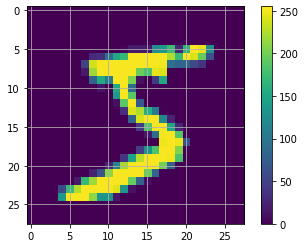

In [10]:

plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.grid(True)

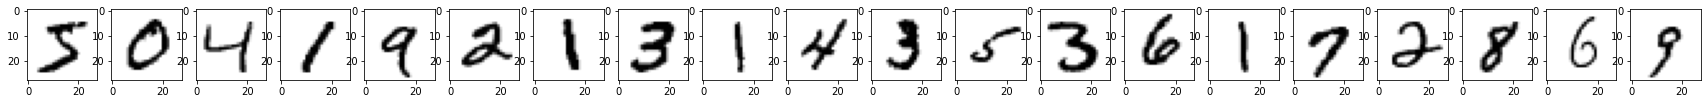

In [12]:
plt.figure(figsize = (30,10))
for i in range(20):
  plt.subplot(5,20,i+1)
#   plt.xticks([])
#   plt.yticks([])
  plt.imshow(x_train[i], cmap = plt.cm.binary)
  #plt.xlabel(class_names[y_train[i]])

In [ ]:
# Create Dataset objects

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset.element_spec

(TensorSpec(shape=(28, 28), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.uint8, name=None))

In [13]:
# Normalise pixel values in the Datasets

def normalise_pixels(image, label):
    return (tf.cast(image, tf.float32) / 255., label)

train_dataset = train_dataset.map(normalise_pixels)
test_dataset = test_dataset.map(normalise_pixels)

NameError: ignored

In [ ]:
# Shuffle and batch the dataset

train_dataset = train_dataset.shuffle(1000).batch(60)
test_dataset = test_dataset.batch(60)

We now define an MLP classifier model for the MNIST dataset. The following demonstrates how to build a model using [the functional API](https://www.tensorflow.org/guide/keras/functional).

In [ ]:
class ActivationStatistics(tf.keras.layers.Layer):
    
    def __init__(self, decay, **kwargs):
        super().__init__(**kwargs)
        self.decay = decay
        
    def build(self, input_shape):
        units = input_shape[-1]
        self.mean = self.add_weight('mean', shape=(units,), dtype=tf.float32,
                                   initializer=tf.zeros_initializer,
                                   trainable=False)
        self.var = self.add_weight('var', shape=(units,), dtype=tf.float32,
                                   initializer=tf.zeros_initializer,
                                   trainable=False)
        
    def call(self, inputs):
        mean, var = tf.nn.moments(inputs, axes=[0])
        delta_mean = (self.mean - mean) * self.decay
        delta_var = (self.var - var) * self.decay
        self.mean.assign_sub(delta_mean)
        self.var.assign_sub(delta_var)
        return inputs

In [ ]:
# Build the classifier model using the functional API

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Input

inputs = Input(shape=(28, 28))
h = Flatten()(inputs)
h = Dense(100, kernel_initializer=tf.random_normal_initializer)(h)
h = ActivationStatistics(0.1, name='act_stats_1')(h)
h = tf.keras.activations.sigmoid(h)
h = Dense(100, kernel_initializer=tf.random_normal_initializer)(h)
h = ActivationStatistics(0.1, name='act_stats_2')(h)
h = tf.keras.activations.sigmoid(h)
h = Dense(100, kernel_initializer=tf.random_normal_initializer)(h)
h = ActivationStatistics(0.1, name='act_stats_3')(h)
h = tf.keras.activations.sigmoid(h)
outputs = Dense(10, activation='softmax')(h)

no_bn_model = Model(inputs=inputs, outputs=outputs)

In [ ]:
# Print the model summary

no_bn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 act_stats_1 (ActivationStat  (None, 100)              200       
 istics)                                                         
                                                                 
 tf.math.sigmoid (TFOpLambda  (None, 100)              0         
 )                                                               
                                                                 
 dense_1 (Dense)             (None, 100)               10100 

In [ ]:
# Define a loss function, optimiser and metric

no_bn_model.compile(loss='sparse_categorical_crossentropy', 
                    optimizer='sgd')


In [ ]:
# Fit the model

def train_model(model):
    activation_stats = []
    accuracy_scores = []
    accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    epochs = 50
    for epoch in range(epochs):
        for images, labels in train_dataset:
            model.train_on_batch(images, labels)

        epoch_stats = []
        for layer_name in ['act_stats_1', 'act_stats_2', 'act_stats_3']:
            layer = model.get_layer(layer_name)
            epoch_stats.append(layer.mean.numpy())
            epoch_stats.append(layer.var.numpy())

        activation_stats.append(epoch_stats)

        for images, labels in test_dataset:
            accuracy_metric.update_state(labels, model(images))
        accuracy_scores.append(accuracy_metric.result())
        accuracy_metric.reset_states()
        print("End of epoch {}".format(epoch))
    return accuracy_scores, activation_stats

In [ ]:
no_bn_accuracy_scores, no_bn_activation_stats = train_model(no_bn_model)

End of epoch 0
End of epoch 1
End of epoch 2
End of epoch 3
End of epoch 4
End of epoch 5
End of epoch 6
End of epoch 7
End of epoch 8
End of epoch 9
End of epoch 10
End of epoch 11
End of epoch 12
End of epoch 13
End of epoch 14
End of epoch 15
End of epoch 16
End of epoch 17
End of epoch 18
End of epoch 19
End of epoch 20
End of epoch 21
End of epoch 22
End of epoch 23
End of epoch 24
End of epoch 25
End of epoch 26
End of epoch 27
End of epoch 28
End of epoch 29
End of epoch 30
End of epoch 31
End of epoch 32
End of epoch 33
End of epoch 34
End of epoch 35
End of epoch 36
End of epoch 37
End of epoch 38
End of epoch 39
End of epoch 40
End of epoch 41
End of epoch 42
End of epoch 43
End of epoch 44
End of epoch 45
End of epoch 46
End of epoch 47
End of epoch 48
End of epoch 49


In [ ]:
# Re-build the model with batch normalisation

from tensorflow.keras.layers import BatchNormalization

inputs = Input(shape=(28, 28))
h = Flatten()(inputs)
h = Dense(100, kernel_initializer=tf.random_normal_initializer)(h)
h = ActivationStatistics(0.1, name='act_stats_1')(h)
h = tf.keras.activations.sigmoid(h)
h = BatchNormalization()(h)
h = Dense(100, kernel_initializer=tf.random_normal_initializer)(h)
h = ActivationStatistics(0.1, name='act_stats_2')(h)
h = tf.keras.activations.sigmoid(h)
h = BatchNormalization()(h)
h = Dense(100, kernel_initializer=tf.random_normal_initializer)(h)
h = ActivationStatistics(0.1, name='act_stats_3')(h)
h = tf.keras.activations.sigmoid(h)
h = BatchNormalization()(h)
outputs = tf.keras.layers.Dense(10, activation='softmax')(h)

bn_model = Model(inputs=inputs, outputs=outputs)

In [ ]:
# Compile the model 

bn_model.compile(loss='sparse_categorical_crossentropy', 
                 optimizer='sgd')

In [ ]:
# Fit the model

bn_accuracy_scores, bn_activation_stats = train_model(bn_model)

End of epoch 0
End of epoch 1
End of epoch 2
End of epoch 3
End of epoch 4
End of epoch 5
End of epoch 6
End of epoch 7
End of epoch 8
End of epoch 9
End of epoch 10
End of epoch 11
End of epoch 12
End of epoch 13
End of epoch 14
End of epoch 15
End of epoch 16
End of epoch 17
End of epoch 18
End of epoch 19
End of epoch 20
End of epoch 21
End of epoch 22
End of epoch 23
End of epoch 24
End of epoch 25
End of epoch 26
End of epoch 27
End of epoch 28
End of epoch 29
End of epoch 30
End of epoch 31
End of epoch 32
End of epoch 33
End of epoch 34
End of epoch 35
End of epoch 36
End of epoch 37
End of epoch 38
End of epoch 39
End of epoch 40
End of epoch 41
End of epoch 42
End of epoch 43
End of epoch 44
End of epoch 45
End of epoch 46
End of epoch 47
End of epoch 48
End of epoch 49


We will compare the progress of the test accuracy in both models.

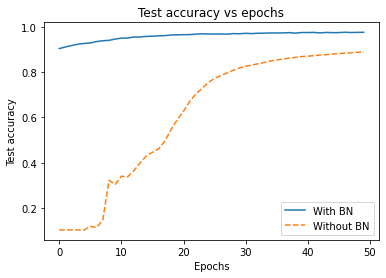

In [ ]:
# Plot the test accuracy

import matplotlib.pyplot as plt

plt.plot(bn_accuracy_scores)
plt.plot(no_bn_accuracy_scores, '--')
plt.legend(['With BN', 'Without BN'])
plt.ylabel("Test accuracy")
plt.xlabel("Epochs")
plt.title("Test accuracy vs epochs")
plt.show()

We see clearly in the above plot that the batch normalisation layers help the model to train faster, and to a higher accuracy.

Batch normalisation reduces internal covariate shift, particularly early on in training. The distribution is more stable, making learning easier.

In [ ]:
import numpy as np

no_bn_activation_stats = np.array(no_bn_activation_stats)
bn_activation_stats = np.array(bn_activation_stats)

bn_activation_stats.shape

(50, 6, 100)

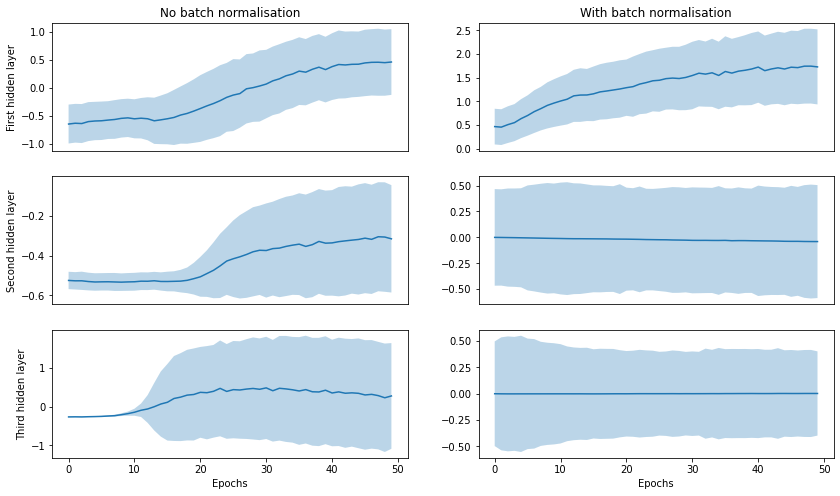

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(14, 8))

def plot_stat(row, col, mean_var):
    mean, var = mean_var[:, 0], mean_var[:, 1]
    axes[row, col].plot(np.arange(len(mean)), mean)
    axes[row, col].fill_between(np.arange(len(mean)),
                               mean- np.sqrt(var),
                                mean + np.sqrt(var),
                                alpha=0.3)
    
feature_index = 78
    
plot_stat(0, 0, no_bn_activation_stats[:, :2, feature_index])
plot_stat(1, 0, no_bn_activation_stats[:, 2:4, feature_index])
plot_stat(2, 0, no_bn_activation_stats[:, 4:, feature_index])
plot_stat(0, 1, bn_activation_stats[:, :2, feature_index])
plot_stat(1, 1, bn_activation_stats[:, 2:4, feature_index])
plot_stat(2, 1, bn_activation_stats[:, 4:, feature_index])
axes[0, 0].set_title("No batch normalisation")
axes[0, 1].set_title("With batch normalisation")
axes[0, 0].get_xaxis().set_visible(False)
axes[0, 1].get_xaxis().set_visible(False)
axes[1, 0].get_xaxis().set_visible(False)
axes[1, 1].get_xaxis().set_visible(False)
axes[0, 0].set_ylabel("First hidden layer")
axes[1, 0].set_ylabel("Second hidden layer")
axes[2, 0].set_ylabel("Third hidden layer")
axes[2, 0].set_xlabel("Epochs")
axes[2, 1].set_xlabel("Epochs")
plt.show()

#### Computation graph

In [ ]:
import tensorflow as tf

In [ ]:
inputs = vgg.inputs
layer_names = ['block1_conv2', 
               'block2_conv2', 
               'block3_conv4', 
               'block4_conv4', 
               'block5_conv4']
outputs = [vgg.get_layer(layer_name).output for layer_name in layer_names]
vgg_features = Model(inputs=inputs, outputs=outputs)


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model1 = Sequential([
    Dense(64, activation='relu', input_shape=(16,)),
    Dense(10, activation='softmax')
])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                1088      
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 1,738
Trainable params: 1,738
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2 = Sequential([
    Dense(128, activation='sigmoid', input_shape=(64,)),
    Dense(32, activation='sigmoid'),
    Dense(1)
])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 32)                4128      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,481
Trainable params: 12,481
Non-trainable params: 0
_________________________________________________________________


In [ ]:
inputs = model1.inputs
outputs = model2.outputs
outputs

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_6')>]

In [ ]:
from tensorflow.keras import Model

model3 = Model(inputs=inputs, outputs=outputs)